In [30]:
n_items = 1500
n_users = 600

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import psutil

# from pyspark.sql import SparkSession

from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, RandomRec
# from replay.models.old_bandits.lin_ucb import LinUCB
# from replay.models.old_bandits.lin_ts import LinTS
from replay.models import UCB, RandomRec, LinUCB, LinTS
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
)

from replay.experimental.scenarios.movielens_wrapper.modified_ips import Exp_Smooth_IPS_Min, Exp_Smooth_IPS_Max

In [35]:
from rs_datasets import MovieLens

data = MovieLens("1m")

In [36]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_items = logs.iloc[:n_items]['item_id'].tolist()

In [37]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (869950, 5)


In [38]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['user_id', 'cnt']].groupby(by=["user_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_users = logs.iloc[:n_users]['user_id'].tolist()

In [39]:
data.ratings = data.ratings[data.ratings['user_id'].isin(popular_users)]
print('размер датасета логов после выброса непопулярных юзеров:', data.ratings.shape)

размер датасета логов после выброса непопулярных юзеров: (313742, 5)


In [40]:
items = set(data.ratings['item_id'].tolist())
users = set(data.ratings['user_id'].tolist())

In [41]:
data.items = data.items[data.items['item_id'].isin(items)]
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((600, 5), (1500, 3))

In [42]:
dataset = MovielensBanditDataset(data)

21-Oct-24 18:53:20, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
21-Oct-24 18:53:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
21-Oct-24 18:53:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model


In [43]:
dataset.context.shape

(313742, 28)

In [44]:
dataset.pscore

array([0.00047309, 0.00147602, 0.00158358, ..., 0.00043823, 0.00172168,
       0.00032693])

In [45]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)
print('train_size:', bandit_feedback_train["n_rounds"])
print('test_size:', bandit_feedback_test["n_rounds"])

24/10/21 18:53:22 WARN TaskSetManager: Stage 5862 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.
24/10/21 18:53:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/21 18:53:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/21 18:53:22 WARN TaskSetManager: Stage 5865 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.
24/10/21 18:53:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/21 18:53:22 WARN TaskSetManager: Stage 5868 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


train_size: 219618
test_size: 94124


24/10/21 18:53:22 WARN TaskSetManager: Stage 5873 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


In [46]:
viewed_items = bandit_feedback_train["log"].toPandas().groupby("user_idx")["item_idx"].apply(list)

In [47]:
viewed_items_all = { i: viewed_items[i] if i in viewed_items.index else [] for i in range(n_users)}

In [48]:
viewed_items_for_test = [viewed_items_all[item_idx] for item_idx in bandit_feedback_test['log'].toPandas()['user_idx'].values]

In [49]:
viewed_items_for_test = np.array(viewed_items_for_test)

In [50]:
viewed_items_for_test

array([list([382, 1, 26, 121, 95, 53, 268, 1477, 1325, 1306, 819, 433, 117, 1021, 25, 0, 54, 884, 958, 591, 1390, 1424, 555, 155, 184, 16, 308, 669, 36, 83, 193, 702, 802, 1087, 149, 509, 118, 1031, 97, 146, 137, 349, 358, 38, 243, 400, 205, 1340, 216, 502, 181, 237, 212, 1357, 293, 1007, 206, 208, 141, 728, 102, 406, 14, 40, 78, 91, 46, 18, 887, 124, 410, 515, 301, 122, 79, 128, 81, 8, 830, 476, 1235, 1380, 687, 526, 387, 449, 1346, 957, 173, 1247, 614, 549, 187, 1114, 1038, 1382, 1409, 238, 62, 590, 316, 1470, 999, 618, 453, 1095, 353, 48, 23, 13, 9, 210, 629, 719, 1101, 579, 415, 800, 540, 1111, 788, 35, 798, 581, 481, 323, 659, 993, 1015, 1351, 76, 30, 74, 326, 552, 178, 1212, 550, 463, 457, 145, 200, 755, 152, 1110, 6, 1249, 1122, 103, 668, 204, 15, 235, 259, 870, 138, 244, 87, 370, 165, 1412, 133, 132, 1308, 383, 442, 1161, 228, 544, 312, 198, 267, 70, 1214, 179, 177, 368, 486, 219, 22, 167, 491, 1172]),
       list([382, 1, 26, 121, 95, 53, 268, 1477, 1325, 1306, 819, 433, 117, 

In [51]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

In [52]:
param_borders_1 = {
    "coef": [0, 10],
}
param_borders_2 = {
    "eps": [-10, 10],
    "alpha": [0.001, 10]
}
param_borders_3 = {
    "distribution": ["popular_based", "relevance"],
    "alpha": [-0.5, 1000],
}
param_borders_4 = {
    "nu": [0.001, 10],
    "alpha": [100, 1500]
}

model_1 = UCB(exploration_coef = 0.009720683864699153, sample = True, seed = 123)
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1)

model_2 = LinUCB(eps = -10, alpha = 10, regr_type = 'disjoint')
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2)

model_3 = RandomRec(distribution = 'relevance', alpha = 153.974492960275, seed=42)
learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3)

model_4 = LinTS(nu = 9.585195706830213, alpha = 140.03084149742904, regr_type = 'disjoint')
learner_4 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_4)

In [53]:
# bandit_feedback_optimize = bandit_subset([0, 100000], bandit_feedback_train)
# learner_1.optimize(bandit_feedback_optimize, val_size=0.3, param_borders=param_borders_1, budget=20)

In [54]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB, LinTS)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, log_distinct.shape[0])
            if j == batch_idx*batch_size:
                break
            log_subset = log_distinct.iloc[batch_idx*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == batch_idx*batch_size:
                break
            bandit_feedback_subset = bandit_subset([batch_idx*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[batch_idx*batch_size:j] = action_dist
    return all_action_dist

In [55]:
learner_1.fit(bandit_feedback_train)
all_action_dist_1 = get_dist(learner_1)

24/10/21 18:53:48 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:53:48 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:53:48 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:53:48 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
100%|██████████| 314/314 [00:54<00:00,  5.79it/s]


In [56]:
learner_2.fit(bandit_feedback_train)
all_action_dist_2 = get_dist(learner_2)

24/10/21 18:55:16 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:55:16 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:55:16 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:55:16 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
100%|██████████| 39/39 [00:10<00:00,  3.55it/s]


In [57]:
learner_3.fit(bandit_feedback_train)
all_action_dist_3 = get_dist(learner_3)

24/10/21 18:55:31 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:55:31 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:55:32 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/10/21 18:55:32 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
100%|██████████| 314/314 [00:53<00:00,  5.92it/s]


In [58]:
np.save(f'UCB_policy', all_action_dist_1)
np.save(f'Lin_UCB_policy', all_action_dist_2)
np.save(f'Random_policy', all_action_dist_3)

In [60]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 26.7


In [69]:
new_log = dataset.log.toPandas().copy()
map_pop_dist = new_log['item_idx'].value_counts(normalize=True)
pop_dist = map_pop_dist.loc[dataset.action].values
pop_dist_test = map_pop_dist.loc[bandit_feedback_test['action']].values

24/10/21 19:05:17 WARN TaskSetManager: Stage 18357 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


In [70]:
any_dist = np.random.rand(bandit_feedback_test['n_actions'])
any_dist = np.exp(any_dist)/ np.exp(any_dist).sum()
any_dist_test = np.array([any_dist[i] for i in bandit_feedback_test['action']])
any_dist_train = np.array([any_dist[i] for i in dataset.action])

In [71]:
any_dist_train.shape

(313742,)

In [64]:
import torch
def CrossEntropyLoss_my(pred, labels, kl_dist, pop_dist, alpha):
    log_loss = torch.nn.functional.cross_entropy(pred,labels)
    probs = torch.nn.functional.softmax(pred, dim=1)
    my_reg = (((kl_dist/ probs)[np.arange(labels.shape[0]), labels].sum() - 1)**2 + ((pop_dist / probs[np.arange(labels.shape[0]), labels]).sum() - 1)**2)/(2 * labels.shape[0]**2)
    # kl_reg = torch.mean(torch.sum((kl_dist * torch.log(kl_dist/torch.nn.functional.softmax(pred, dim=1))), dim=1))
    return log_loss + alpha * my_reg

def CrossEntropyLoss_oh(pred, labels, kl_dist, pop_dist, alpha):
    log_loss = torch.nn.functional.cross_entropy(pred,labels)
    kl_reg = torch.mean(torch.sum((kl_dist * torch.log(kl_dist/torch.nn.functional.softmax(pred, dim=1))), dim=1))
    return log_loss + alpha * kl_reg

class my_Model(torch.nn.Module):
    def __init__(self,cnt_feat, num_classes, hidden_size):
        super().__init__()
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(cnt_feat, num_classes, bias=True)           
        )
    def forward(self, x):
        return self.lin(x)

class Behavior_Clone_Model:
    def __init__(self, cnt_feat, num_classes, hidden_size, type_loss, lr, n_epochs, batch_size, alpha):
        self.n_epochs = n_epochs  # epochs
        self.lr = lr  # learning rate
        self.batch_size = batch_size #batch_size
        self.alpha = alpha #param of regul
        # model
        self.model = my_Model(cnt_feat, num_classes, hidden_size)
        self.num_classes = num_classes

    def fit(self, x_train, Y_train, x_test, Y_test, pop_dist, pop_dist_test):
        # training graph and optimization
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # loss and accuracy storage
        cnt_batch_per_epoch = Y_train.size//self.batch_size
        self.model.train()
        for epoch in range(self.n_epochs*cnt_batch_per_epoch + 1):
            # randomic batch definition
            rbatch = np.random.choice(Y_train.size, size=self.batch_size)
            # variables initialization
            X = torch.autograd.Variable(torch.FloatTensor(x_train[rbatch]))
            Y = torch.LongTensor(Y_train[rbatch].astype(np.int))
            dist_batch = torch.FloatTensor(np.ones((self.batch_size, self.num_classes))* (1/self.num_classes))
            pop_dist_batch = torch.FloatTensor(pop_dist[rbatch])
            # training, metrics and storage
            optimizer.zero_grad()
            pred = self.model(X)
            L = CrossEntropyLoss_my(pred, Y, dist_batch, pop_dist_batch, self.alpha)
            L.backward()
            optimizer.step()

            if epoch%1000 == 0:
                self.model.eval()
                with torch.no_grad():
                    X_ = torch.autograd.Variable(torch.FloatTensor(x_test))
                    pred_test = self.model(X_)
                    Y_ = torch.LongTensor(Y_test)
                    dist_test = torch.FloatTensor(np.ones((Y_.shape[0], self.num_classes))* (1/self.num_classes))
                    pop_test = torch.FloatTensor(pop_dist_test)
                    loss_test = CrossEntropyLoss_my(pred_test, Y_, dist_test, pop_test, self.alpha)
                    print('epoch', epoch, 'ce_loss_test: ', loss_test.detach())
                print('epoch: {0:04d} | loss: {1:.3f}'.format(epoch, L))
    
    def predict_proba(self, x_test, Y_test):
        self.model.eval()
        with torch.no_grad():
            X_ = torch.autograd.Variable(torch.FloatTensor(x_test))
            probs = torch.nn.functional.softmax(self.model(X_), dim=1).detach().numpy()
        print('acc: ',(np.argmax(probs, axis = 1) == Y_test).mean())
        return probs[np.arange(Y_test.size), Y_test]

In [65]:
num_polices = 25

In [66]:
context_train = dataset.context
action_train = dataset.action
size_subset = int(0.8*context_train.shape[0])
for alpha in [0,  1e-2, 1e-1, 1, 5, 10]:
    behavior_policies = []
    print(alpha, 'start')
    for i in range(num_polices):
        print(i,"start")
        bootstrap_idx = np.random.choice(context_train.shape[0], size=size_subset)
        b_model = Behavior_Clone_Model(context_train.shape[1], bandit_feedback_train['n_actions'], 3000, 'kl', 1e-4, 4, 64, alpha)
        b_model.fit(context_train[bootstrap_idx], action_train[bootstrap_idx], bandit_feedback_test['context'][:10000], bandit_feedback_test['action'][:10000], any_dist_train[bootstrap_idx], any_dist_test[:10000])
        torch.save(b_model.model.state_dict(), f'./models_pi_0_without_id_my_reg_mean_any_dist/model_{i}_alpha_{alpha}.pt')
        behavior_policies.append(b_model.predict_proba(bandit_feedback_test['context'], bandit_feedback_test['action']))
    behavior_policies_np = np.array(behavior_policies)
    np.save(f'behavior_policies_full_without_id_my_reg_mean_any_dist_np_25_alpha={alpha}', behavior_policies_np)

0 start
0 start
epoch 0 ce_loss_test:  tensor(7.3368)
epoch: 0000 | loss: 7.325
epoch 1000 ce_loss_test:  tensor(7.3144)
epoch: 1000 | loss: 7.351
epoch 2000 ce_loss_test:  tensor(7.2984)
epoch: 2000 | loss: 7.290
epoch 3000 ce_loss_test:  tensor(7.2855)
epoch: 3000 | loss: 7.304
epoch 4000 ce_loss_test:  tensor(7.2746)
epoch: 4000 | loss: 7.255
epoch 5000 ce_loss_test:  tensor(7.2651)
epoch: 5000 | loss: 7.248
epoch 6000 ce_loss_test:  tensor(7.2568)
epoch: 6000 | loss: 7.210
epoch 7000 ce_loss_test:  tensor(7.2496)
epoch: 7000 | loss: 7.231
epoch 8000 ce_loss_test:  tensor(7.2435)
epoch: 8000 | loss: 7.198
epoch 9000 ce_loss_test:  tensor(7.2380)
epoch: 9000 | loss: 7.231
epoch 10000 ce_loss_test:  tensor(7.2331)
epoch: 10000 | loss: 7.244
epoch 11000 ce_loss_test:  tensor(7.2290)
epoch: 11000 | loss: 7.187
epoch 12000 ce_loss_test:  tensor(7.2254)
epoch: 12000 | loss: 7.217
epoch 13000 ce_loss_test:  tensor(7.2223)
epoch: 13000 | loss: 7.170
epoch 14000 ce_loss_test:  tensor(7.2197)

RuntimeError: Parent directory ./models_pi_0_without_id_my_reg_mean_any_dist does not exist.

In [24]:
def ipw(pi_e, pi_0, r, r_hat):
    weights = pi_e/pi_0
    return weights * r

def snipw(pi_e, pi_0, r, r_hat):
    weights = pi_e/pi_0
    weights = weights/weights.mean()
    return weights * r
    
def sndr(pi_e, pi_0, r, r_hat, dm):
    weights = pi_e/pi_0
    weights = weights/weights.mean()
    return dm + weights*(r-r_hat)

def dm(dm):
    return dm
    

In [92]:
r_hat = estimated_rewards_by_reg_model[np.arange(bandit_feedback_test['action'].shape[0]), bandit_feedback_test['action'], 0]

In [93]:
DM_method_1 = (estimated_rewards_by_reg_model * all_action_dist_1).sum(axis = 1).squeeze()
DM_method_2 = (estimated_rewards_by_reg_model * all_action_dist_2).sum(axis = 1).squeeze()
DM_method_3 = (estimated_rewards_by_reg_model * all_action_dist_3).sum(axis = 1).squeeze()

In [130]:
# np.save(f'DM_method_1', DM_method_1)
# np.save(f'DM_method_2', DM_method_2)
# np.save(f'DM_method_3', DM_method_3)

In [91]:
all_action_dist_1 = np.load("UCB_policy.npy")
all_action_dist_2 = np.load("Lin_UCB_policy.npy")
all_action_dist_3 = np.load("Random_policy.npy")

In [113]:
all_action_dist_1[0, : ,0]

array([0.00079178, 0.00079155, 0.00077414, ..., 0.00076017, 0.00059812,
       0.00050405])

In [95]:
all_action_dist_1_new = all_action_dist_1.copy()
for i in range(all_action_dist_1.shape[0]):
    all_action_dist_1_new[i][viewed_items_for_test[i]] = 0
    all_action_dist_1_new[i]/= all_action_dist_1_new[i].sum()

In [96]:
all_action_dist_2_new = all_action_dist_2.copy()
for i in range(all_action_dist_2.shape[0]):
    all_action_dist_2_new[i][viewed_items_for_test[i]] = 0
    all_action_dist_2_new[i]/= all_action_dist_2_new[i].sum()

In [97]:
all_action_dist_3_new = all_action_dist_3.copy()
for i in range(all_action_dist_3.shape[0]):
    all_action_dist_3_new[i][viewed_items_for_test[i]] = 0
    all_action_dist_3_new[i]/= all_action_dist_3_new[i].sum()

In [98]:
all_action_dist_1_top_10 = all_action_dist_1_new.copy()
idx_1 = np.argsort(-all_action_dist_1_top_10, axis = 1)
for i in range(all_action_dist_1_top_10.shape[0]):
    all_action_dist_1_top_10[i][idx_1[i][10:]] = 0
    all_action_dist_1_top_10[i] /= all_action_dist_1_top_10[i].sum()

In [99]:
all_action_dist_2_top_10 = all_action_dist_2_new.copy()
idx_2 = np.argsort(-all_action_dist_2_top_10, axis = 1)
for i in range(all_action_dist_2_top_10.shape[0]):
    all_action_dist_2_top_10[i][idx_2[i][10:]] = 0
    all_action_dist_2_top_10[i] /= all_action_dist_2_top_10[i].sum()

In [100]:
all_action_dist_3_top_10 = all_action_dist_3_new.copy()
idx_3 = np.argsort(-all_action_dist_3_top_10, axis = 1)
for i in range(all_action_dist_3_top_10.shape[0]):
    all_action_dist_3_top_10[i][idx_3[i][10:]] = 0
    all_action_dist_3_top_10[i] /= all_action_dist_3_top_10[i].sum()

In [165]:
all_action_dist_1_top_10[5].sum()

1.0

In [101]:
DM_method_1_new = (estimated_rewards_by_reg_model * all_action_dist_1_new).sum(axis = 1).squeeze()
DM_method_2_new = (estimated_rewards_by_reg_model * all_action_dist_2_new).sum(axis = 1).squeeze()
DM_method_3_new = (estimated_rewards_by_reg_model * all_action_dist_3_new).sum(axis = 1).squeeze()

In [102]:
DM_method_1_top_10 = (estimated_rewards_by_reg_model * all_action_dist_1_top_10).sum(axis = 1).squeeze()
DM_method_2_top_10 = (estimated_rewards_by_reg_model * all_action_dist_2_top_10).sum(axis = 1).squeeze()
DM_method_3_top_10 = (estimated_rewards_by_reg_model * all_action_dist_3_top_10).sum(axis = 1).squeeze()

In [67]:
# DM_method_1 = np.load('DM_method_1.npy')
# DM_method_2 = np.load('DM_method_2.npy')
# DM_method_3 = np.load('DM_method_3.npy')

In [123]:
def run_exp(all_action_dist, DM_method):
    metrics = ['ipw', 'snipw', 'sndr', 'dm']
    pi_e = all_action_dist[np.arange(bandit_feedback_test['action'].shape[0]), bandit_feedback_test['action'], 0].copy()
    cnt_inner_bootstraps = 100
    _alpha = 0.05
    CIs = []
    prefixs = ['behavior_policies_full_without_id_my_reg_mean_any_dist']#['behavior_policies_full', 'behavior_policies_full_without_id_my_reg_mean', 'behavior_policies_full_without_id', 'behavior_policies_full_without_id_my_reg_mean_any_dist']
    for n_size in [10000, 20000, 50000, 70000, 94124]:
        res = {}
        pi_e_subset = pi_e[:n_size].copy()
        r_hat_subset = r_hat[:n_size].copy()
        r_subset = bandit_feedback_test['reward'][:n_size].copy()
        dm_subset = DM_method[:n_size].copy()
        stats = {}
        print(n_size)
        for metric in metrics:
            stats[metric] = []
        for prefix in prefixs:
            alpha = 0 
            behavior_policies = np.load(f"{prefix}_np_25_alpha={alpha}.npy")
            for i in range(num_polices):
                pi_0_subset= all_action_dist_3[np.arange(bandit_feedback_test['action'].shape[0]), bandit_feedback_test['action'], 0][:n_size].copy()#behavior_policies[i][:n_size]

                ipw_est_round_rewards = ipw(pi_e_subset, pi_0_subset, r_subset, r_hat_subset)
                snipw_est_round_rewards = snipw(pi_e_subset, pi_0_subset, r_subset, r_hat_subset)
                sndr_est_round_rewards = sndr(pi_e_subset, pi_0_subset, r_subset, r_hat_subset, dm_subset)
                dm_est_round_rewards = dm(dm_subset)

                for j in range(cnt_inner_bootstraps):
                    bootstrap_idxs = np.random.randint(n_size, size=n_size)
                    stats['ipw'].append(ipw_est_round_rewards[bootstrap_idxs].mean())
                    stats['snipw'].append(snipw_est_round_rewards[bootstrap_idxs].mean())
                    stats['sndr'].append(sndr_est_round_rewards[bootstrap_idxs].mean())
                    stats['dm'].append(dm_est_round_rewards[bootstrap_idxs].mean())
        for metric in metrics:
            dct = {}
            values = stats[metric]
            dct['mean'] = np.mean(values)
            dct['95.0% CI (lower)'] = np.percentile(values, 100 * (_alpha / 2))
            dct['95.0% CI (upper)'] = np.percentile(values, 100 * (1.0 - _alpha / 2))
            res[metric] = dct
        CIs.append(res)
    return CIs

In [124]:
CIs_1 = run_exp(all_action_dist_1_top_10, DM_method_1_top_10)

10000
20000
50000
70000
94124


In [125]:
CIs_2 = run_exp(all_action_dist_2_top_10, DM_method_2_top_10)

10000
20000
50000
70000
94124


In [126]:
CIs_3 = run_exp(all_action_dist_3_top_10, DM_method_3_top_10)

10000
20000
50000
70000
94124


In [127]:
CIs_1[-1]

{'ipw': {'mean': 1.041885275948386,
  '95.0% CI (lower)': 0.9204316135758553,
  '95.0% CI (upper)': 1.1604932127409016},
 'snipw': {'mean': 0.9262359267529539,
  '95.0% CI (lower)': 0.8182636306450526,
  '95.0% CI (upper)': 1.0316783730484647},
 'sndr': {'mean': 0.926192219729574,
  '95.0% CI (lower)': 0.8903922428116986,
  '95.0% CI (upper)': 0.9576386894841326},
 'dm': {'mean': 0.8253706837990188,
  '95.0% CI (lower)': 0.8251967239134227,
  '95.0% CI (upper)': 0.8255347630469807}}

In [128]:
CIs_2[-1]

{'ipw': {'mean': 1.0230459654271686,
  '95.0% CI (lower)': 0.9753451111624567,
  '95.0% CI (upper)': 1.0692258796869134},
 'snipw': {'mean': 0.9404683979375077,
  '95.0% CI (lower)': 0.8966178306056158,
  '95.0% CI (upper)': 0.9829207915233809},
 'sndr': {'mean': 0.9409028907801626,
  '95.0% CI (lower)': 0.9287117921653938,
  '95.0% CI (upper)': 0.9527681094054228},
 'dm': {'mean': 0.8373102823046525,
  '95.0% CI (lower)': 0.8371435520370606,
  '95.0% CI (upper)': 0.8374793757139825}}

In [129]:
CIs_3[-1]

{'ipw': {'mean': 1.0086624369793766,
  '95.0% CI (lower)': 0.9656949840988247,
  '95.0% CI (upper)': 1.053740005258371},
 'snipw': {'mean': 0.9481301762123329,
  '95.0% CI (lower)': 0.9077413036049297,
  '95.0% CI (upper)': 0.9905025311139163},
 'sndr': {'mean': 0.9477231699912992,
  '95.0% CI (lower)': 0.9371635208427741,
  '95.0% CI (upper)': 0.9588064899249399},
 'dm': {'mean': 0.8388684871360882,
  '95.0% CI (lower)': 0.8387140618859202,
  '95.0% CI (upper)': 0.8390268217051302}}

In [130]:
def plot_CIs(CIs_1, CIs_2, CIs_3, model_1, model_2, model_3):
    fig, ax = plt.subplots(4, figsize=(10, 10))
    
    x = [10000, 20000, 50000, 70000, 94124]

    colors = ['b', 'r', 'g', 'y']
    i = 0 
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_1]
        
        ax[i].plot(x, y_est, '-', label=model_1, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_2]
        
        ax[i].plot(x, y_est, '-', label=model_2, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_3]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_3]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_3]
        
        ax[i].plot(x, y_est, '-', label=model_3, color = colors[2])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[2])
        
        ax[i].set_title(name)
        i+=1

    fig.suptitle("OPE for " + " " + model_1 + " " + model_2 + " " + model_2, fontsize=16)
    fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()

In [140]:
users_train = np.unique(bandit_feedback_train['log'].toPandas()['user_idx'].values)

In [141]:
users_test = np.unique(bandit_feedback_test['log'].toPandas()['user_idx'].values)

In [148]:
cold_users = []
for u in  users_test:
    if not (u in users_train):
        cold_users.append(u)
cold_users = np.array(cold_users)

In [149]:
cold_users

array([  5,  15,  20,  33,  41,  42,  44,  47,  70,  84,  89,  96,  98,
       108, 110, 112, 116, 121, 134, 135, 143, 166, 168, 173, 178, 189,
       192, 200, 202, 209, 210, 216, 226, 242, 245, 246, 255, 257, 283,
       297, 299, 302, 304, 310, 311, 316, 318, 342, 360, 362, 368, 371,
       372, 398, 403, 413, 421, 423, 433, 436, 438, 439, 456, 457, 462,
       464, 478, 480, 493, 497, 499, 505, 506, 509, 511, 516, 523, 527,
       528, 532, 538, 539, 544, 555, 557, 570, 578, 595, 599], dtype=int32)

In [156]:
not_cold_idx = (bandit_feedback_test['log'].toPandas()['user_idx'].isin(cold_users)).values

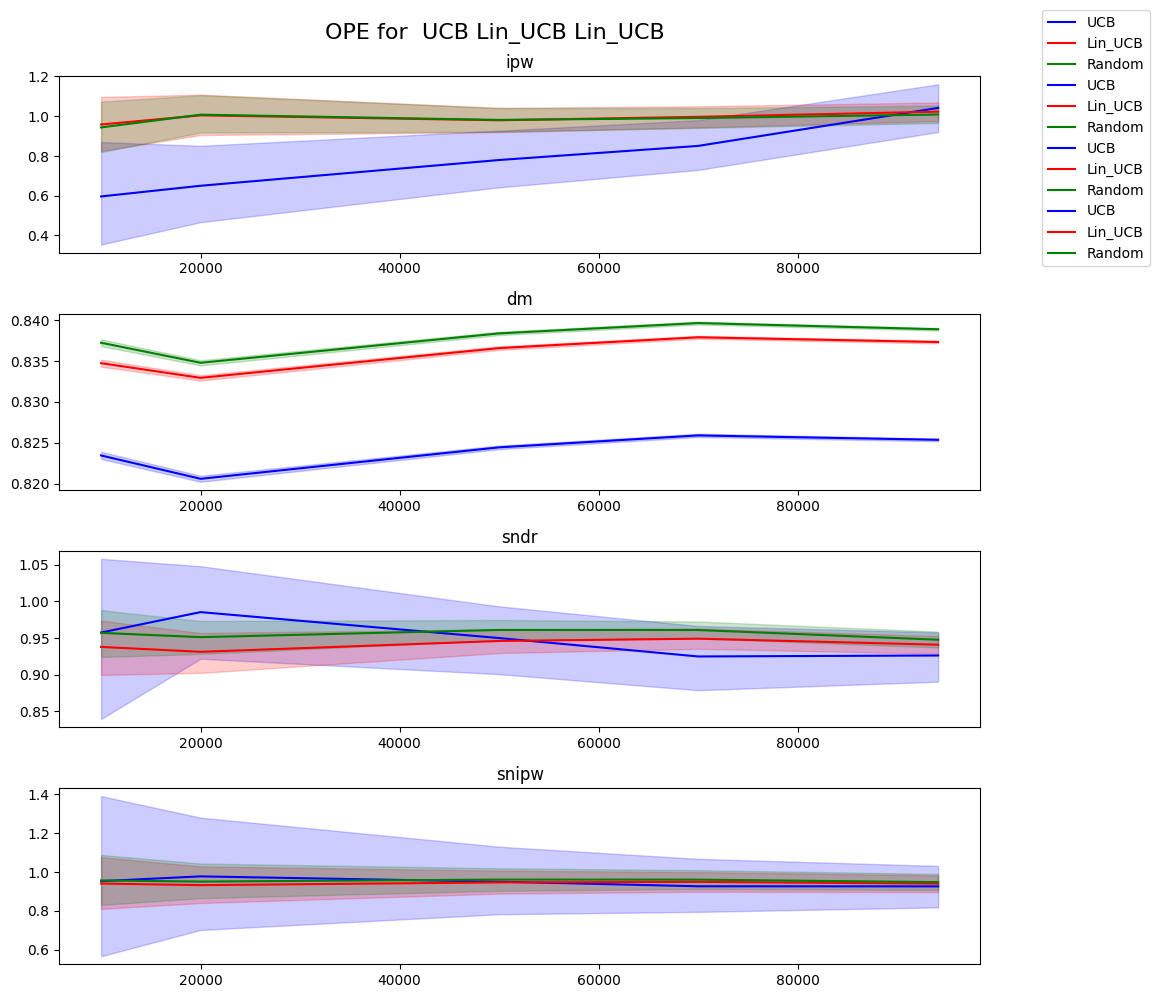

In [131]:
plot_CIs(CIs_1,CIs_2, CIs_3, 'UCB', 'Lin_UCB', 'Random')

In [73]:
learner_1.predict_and_evaluate_new(bandit_feedback_test, K=10)

NameError: name 'learner_1' is not defined

In [73]:
learner_2.predict_and_evaluate_new(bandit_feedback_test, K=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:24<00:00,  1.57it/s]


{'hr@10': 0.04183306807114465,
 'mrr@10': 0.01427059733071232,
 'ndcg@10': 0.020625325468776063,
 'cov@10': 0.24933333333333332}

In [74]:
learner_3.predict_and_evaluate_new(bandit_feedback_test, K=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.16it/s]


{'hr@10': 0.009256523649549911,
 'mrr@10': 0.0027288165025053414,
 'ndcg@10': 0.0042169598803056445,
 'cov@10': 0.9446666666666667}

In [160]:
my_log = bandit_feedback_test['log'].toPandas().copy()
check_map_pop_dist = my_log['item_idx'].value_counts(normalize=True)
check_pop_dist =[]
for a in range(bandit_feedback_test['n_actions']):
    if a in bandit_feedback_test['action']:
        check_pop_dist.append(check_map_pop_dist.loc[[a]].values[0])
    else:
        check_pop_dist.append(0)

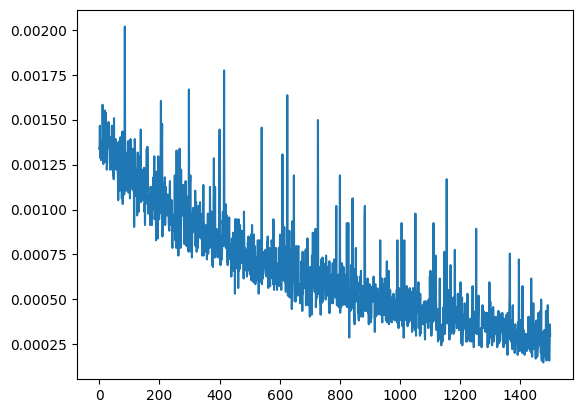

In [162]:
plt.plot(np.arange(bandit_feedback_test['n_actions']), check_pop_dist)

In [163]:
my_log = bandit_feedback_train['log'].toPandas().copy()
check_map_pop_dist = my_log['item_idx'].value_counts(normalize=True)
check_pop_dist =[]
for a in range(bandit_feedback_train['n_actions']):
    if a in bandit_feedback_train['action']:
        check_pop_dist.append(check_map_pop_dist.loc[[a]].values[0])
    else:
        check_pop_dist.append(0)

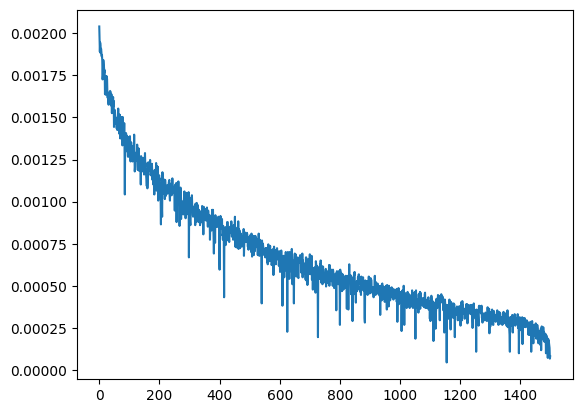

In [164]:
plt.plot(np.arange(bandit_feedback_test['n_actions']), check_pop_dist)